# Kitabxanalar

In [1318]:
import pandas as pd
import numpy as np
import seaborn as sns
import pingouin as pg
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats
from sklearn.neighbors import LocalOutlierFactor
from warnings import filterwarnings
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve,classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
filterwarnings("ignore")

In [1193]:
#datanı çəkirik
df = pd.read_csv("churn.csv")

In [1194]:
#datanın kopyasını alırıq.
data = df.copy()

In [1195]:
#dataya ön baxış.
data.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

# EDA

In [1196]:
#Bir funksiya ilə data haqqında ümumi məlumat əldə etmək üçün funksiya
def info(data):
    """
      Data haqqında ümumi informasiya alır.
      
      param :data: Dataframe.
    """
    
    print("Proses Başladı.\n")
    
    print(f"Datanın Ölçüsü: Sətir : {data.shape[0]}, Sütun: {data.shape[1]}\n")
    
    print(f"Datada Təkrarlanan Sətirlərin Sayı: {data.duplicated().sum()}\n\n")
    
    print(f"Datanın Ümumi Atributlarının Siyahısı.\n")
    print(data.columns.to_list())
    
    print("\nTarget sütunundakı gruplar və onların sayı:")
    print(data["Exited"].value_counts())
    
    
    if len(data.select_dtypes(include = "O").columns)!=0: 
            print(f"\n\nDatanın Object Tip Atributlarının Sayı: {len(data.select_dtypes(include = 'O').columns)}\n")
            print(f"Datanın Object Tip Atributlarının Siyahısı.\n")
            print(data.select_dtypes(include = "O").columns.to_list())

    if len(data.select_dtypes(include = "number").columns)!=0:
            print(f"\n\nDatanın Numeric Tip sütunların Sayı: {len(data.select_dtypes(include = 'number').columns)}\n")
            print(f"Datanın Numeric Tip sütunların Siyahısı.\n")
            print(data.select_dtypes(include = "number").columns.to_list())
            
            
    if data.isnull().any().any():    
        print("\n\nDatadakı Çatışmayan Dəyərlər.\n")  
        for col in [col for col in data.isnull().any().index]:  
            print(f"Sütun Adı: {col}")
            print(f"{col}-Sütunundakı Çatışmayan Dəyərlərin Sayı: {data[col].isnull().sum()}")
            print("#"*20,end="\n\n")       
        print(f"Ümumi Datadakı Çatışmayan Dəyərlərin Sayı: {data.isnull().sum().sum()}")
    else:
        print("\n\nDatanın Heç Bir Sütununda Çatışmayan Dəyər Yoxdur.")  

In [1197]:
info(data)

Proses Başladı.

Datanın Ölçüsü: Sətir : 10000, Sütun: 14

Datada Təkrarlanan Sətirlərin Sayı: 0


Datanın Ümumi Atributlarının Siyahısı.

['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']

Target sütunundakı gruplar və onların sayı:
0    7963
1    2037
Name: Exited, dtype: int64


Datanın Object Tip Atributlarının Sayı: 3

Datanın Object Tip Atributlarının Siyahısı.

['Surname', 'Geography', 'Gender']


Datanın Numeric Tip sütunların Sayı: 11

Datanın Numeric Tip sütunların Siyahısı.

['RowNumber', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


Datanın Heç Bir Sütununda Çatışmayan Dəyər Yoxdur.


In [1198]:
# Row_number və CustomerİD sütunlarını datamızdan kənarlaşdırarıq.
data.drop(columns = ["RowNumber","CustomerId"],axis = 1,inplace = True)

In [1199]:
# Surname sütununda bizim modelə faydası olayacaqından bu sütunuda atırıq.
data.drop(columns = ["Surname"],axis = 1,inplace = True)

In [1200]:
data.head()

CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42       2       0.00              1   
1          608     Spain  Female   41       1   83807.86              1   
2          502    France  Female   42       8  159660.80              3   
3          699    France  Female   39       1       0.00              2   
4          850     Spain  Female   43       2  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0          1               1        101348.88       1  
1          0               1        112542.58       0  
2          1               0        113931.57       1  
3          0               0         93826.63       0  
4          1               1         79084.10       0

In [1201]:
#numeric sütunlar üçün statistikal göstəricilər
data.describe().T

count           mean           std     min       25%  \
CreditScore      10000.0     650.528800     96.653299  350.00    584.00   
Age              10000.0      38.921800     10.487806   18.00     32.00   
Tenure           10000.0       5.012800      2.892174    0.00      3.00   
Balance          10000.0   76485.889288  62397.405202    0.00      0.00   
NumOfProducts    10000.0       1.530200      0.581654    1.00      1.00   
HasCrCard        10000.0       0.705500      0.455840    0.00      0.00   
IsActiveMember   10000.0       0.515100      0.499797    0.00      0.00   
EstimatedSalary  10000.0  100090.239881  57510.492818   11.58  51002.11   
Exited           10000.0       0.203700      0.402769    0.00      0.00   

                        50%          75%        max  
CreditScore         652.000     718.0000     850.00  
Age                  37.000      44.0000      92.00  
Tenure                5.000       7.0000      10.00  
Balance           97198.540  127644.2400  250898.09  
NumOfProducts         1.000       2.0000       4.00  
HasCrCard             1.000       1.0000       1.00  
IsActiveMember        1.000       1.0000       1.00  
EstimatedSalary  100193.915  149388.2475  199992.48  
Exited                0.000       0.0000       1.00

In [1202]:
#category sütunlar üçün statistikal göstəricilər
data.select_dtypes(include ="O").describe().T

count unique     top  freq
Geography  10000      3  France  5014
Gender     10000      2    Male  5457

## Plotlar

In [1203]:
data.head()

CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42       2       0.00              1   
1          608     Spain  Female   41       1   83807.86              1   
2          502    France  Female   42       8  159660.80              3   
3          699    France  Female   39       1       0.00              2   
4          850     Spain  Female   43       2  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0          1               1        101348.88       1  
1          0               1        112542.58       0  
2          1               0        113931.57       1  
3          0               0         93826.63       0  
4          1               1         79084.10       0

In [1204]:
def bar_plot(*columns):
    plt.figure(figsize=(15,10))
    for i,col in enumerate(columns,start = 1):
        plt.subplot(2,3,i)
        data_bar = data.groupby(col)["Exited"].agg(["mean","sum"]).reset_index()
        sns.barplot(data_bar,x = col,y = "sum",hue="mean")
        plt.legend(loc = "best")

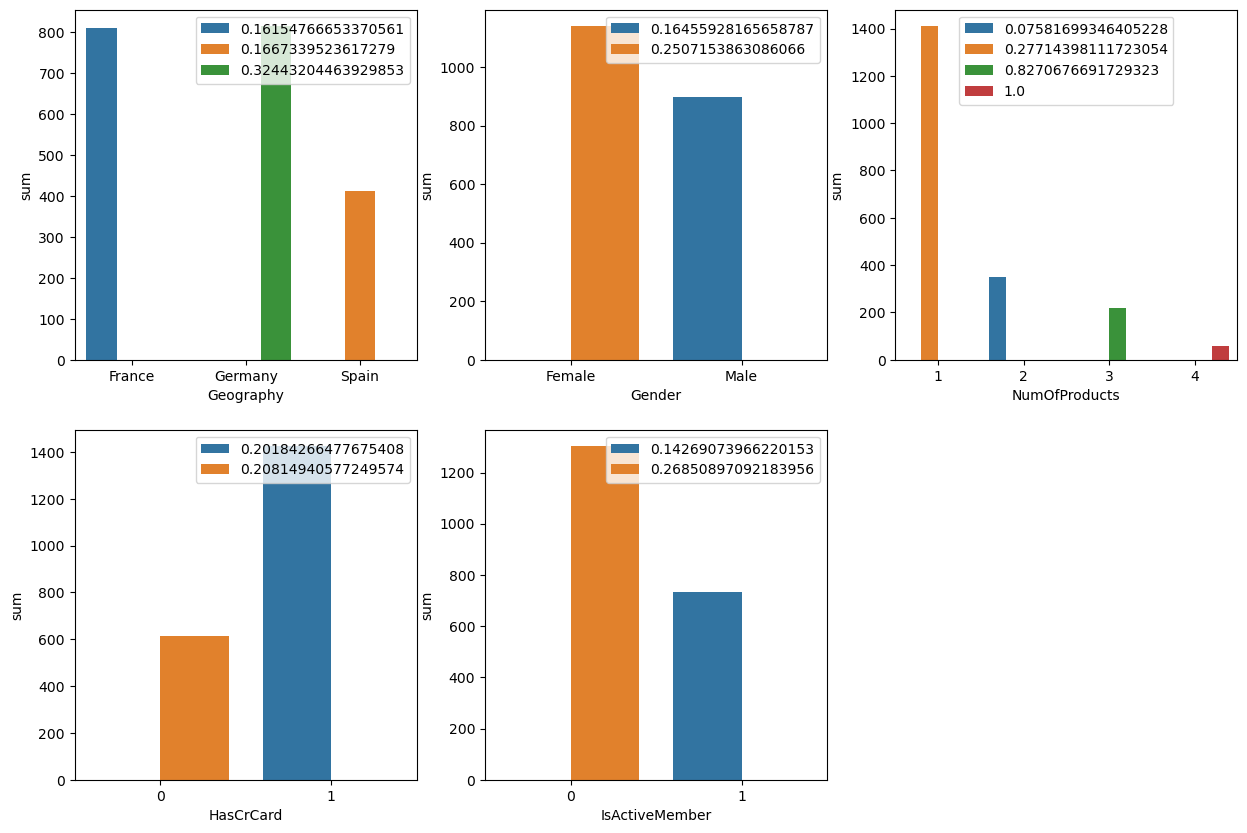

In [1205]:
cols1 = ["Geography","Gender","NumOfProducts","HasCrCard","IsActiveMember"]
bar_plot(*cols1)

1) Farnsız və Alman əsilli müşdərilər daha çox tərk sayına malikdirlər.Lakin faiz olaraq, Alman əsilli müşdərilər  daha çox tərk etmə payına sahibdirlər.
2) Qadınlar daha çox tərk etməyə meyillidirlər və faiz olaraq da kişilərdən daha çox tərk etmə payına sahibdirlər.
3) Məhsul sayı 1 olanlar daha çox tərk etməyə meyillidirlər.
4) Kredit kartı olanlar daha çox tərk etməyə meyil göstərirlər.
5) Aktiv olmayan müşdərilər daha çox tərk etməyə meyil göstərirlər.

In [1206]:
def scatter_plot(data,*columns):
    plt.figure(figsize=(25,30))
    i=1
    for col1 in columns:
        for col2 in columns:
            if col1==col2:
                continue
            plt.subplot(4,3,i)
            sns.scatterplot(data,x = col1,y = col2,hue="Exited")
            plt.legend(loc = "best")
            i=i+1

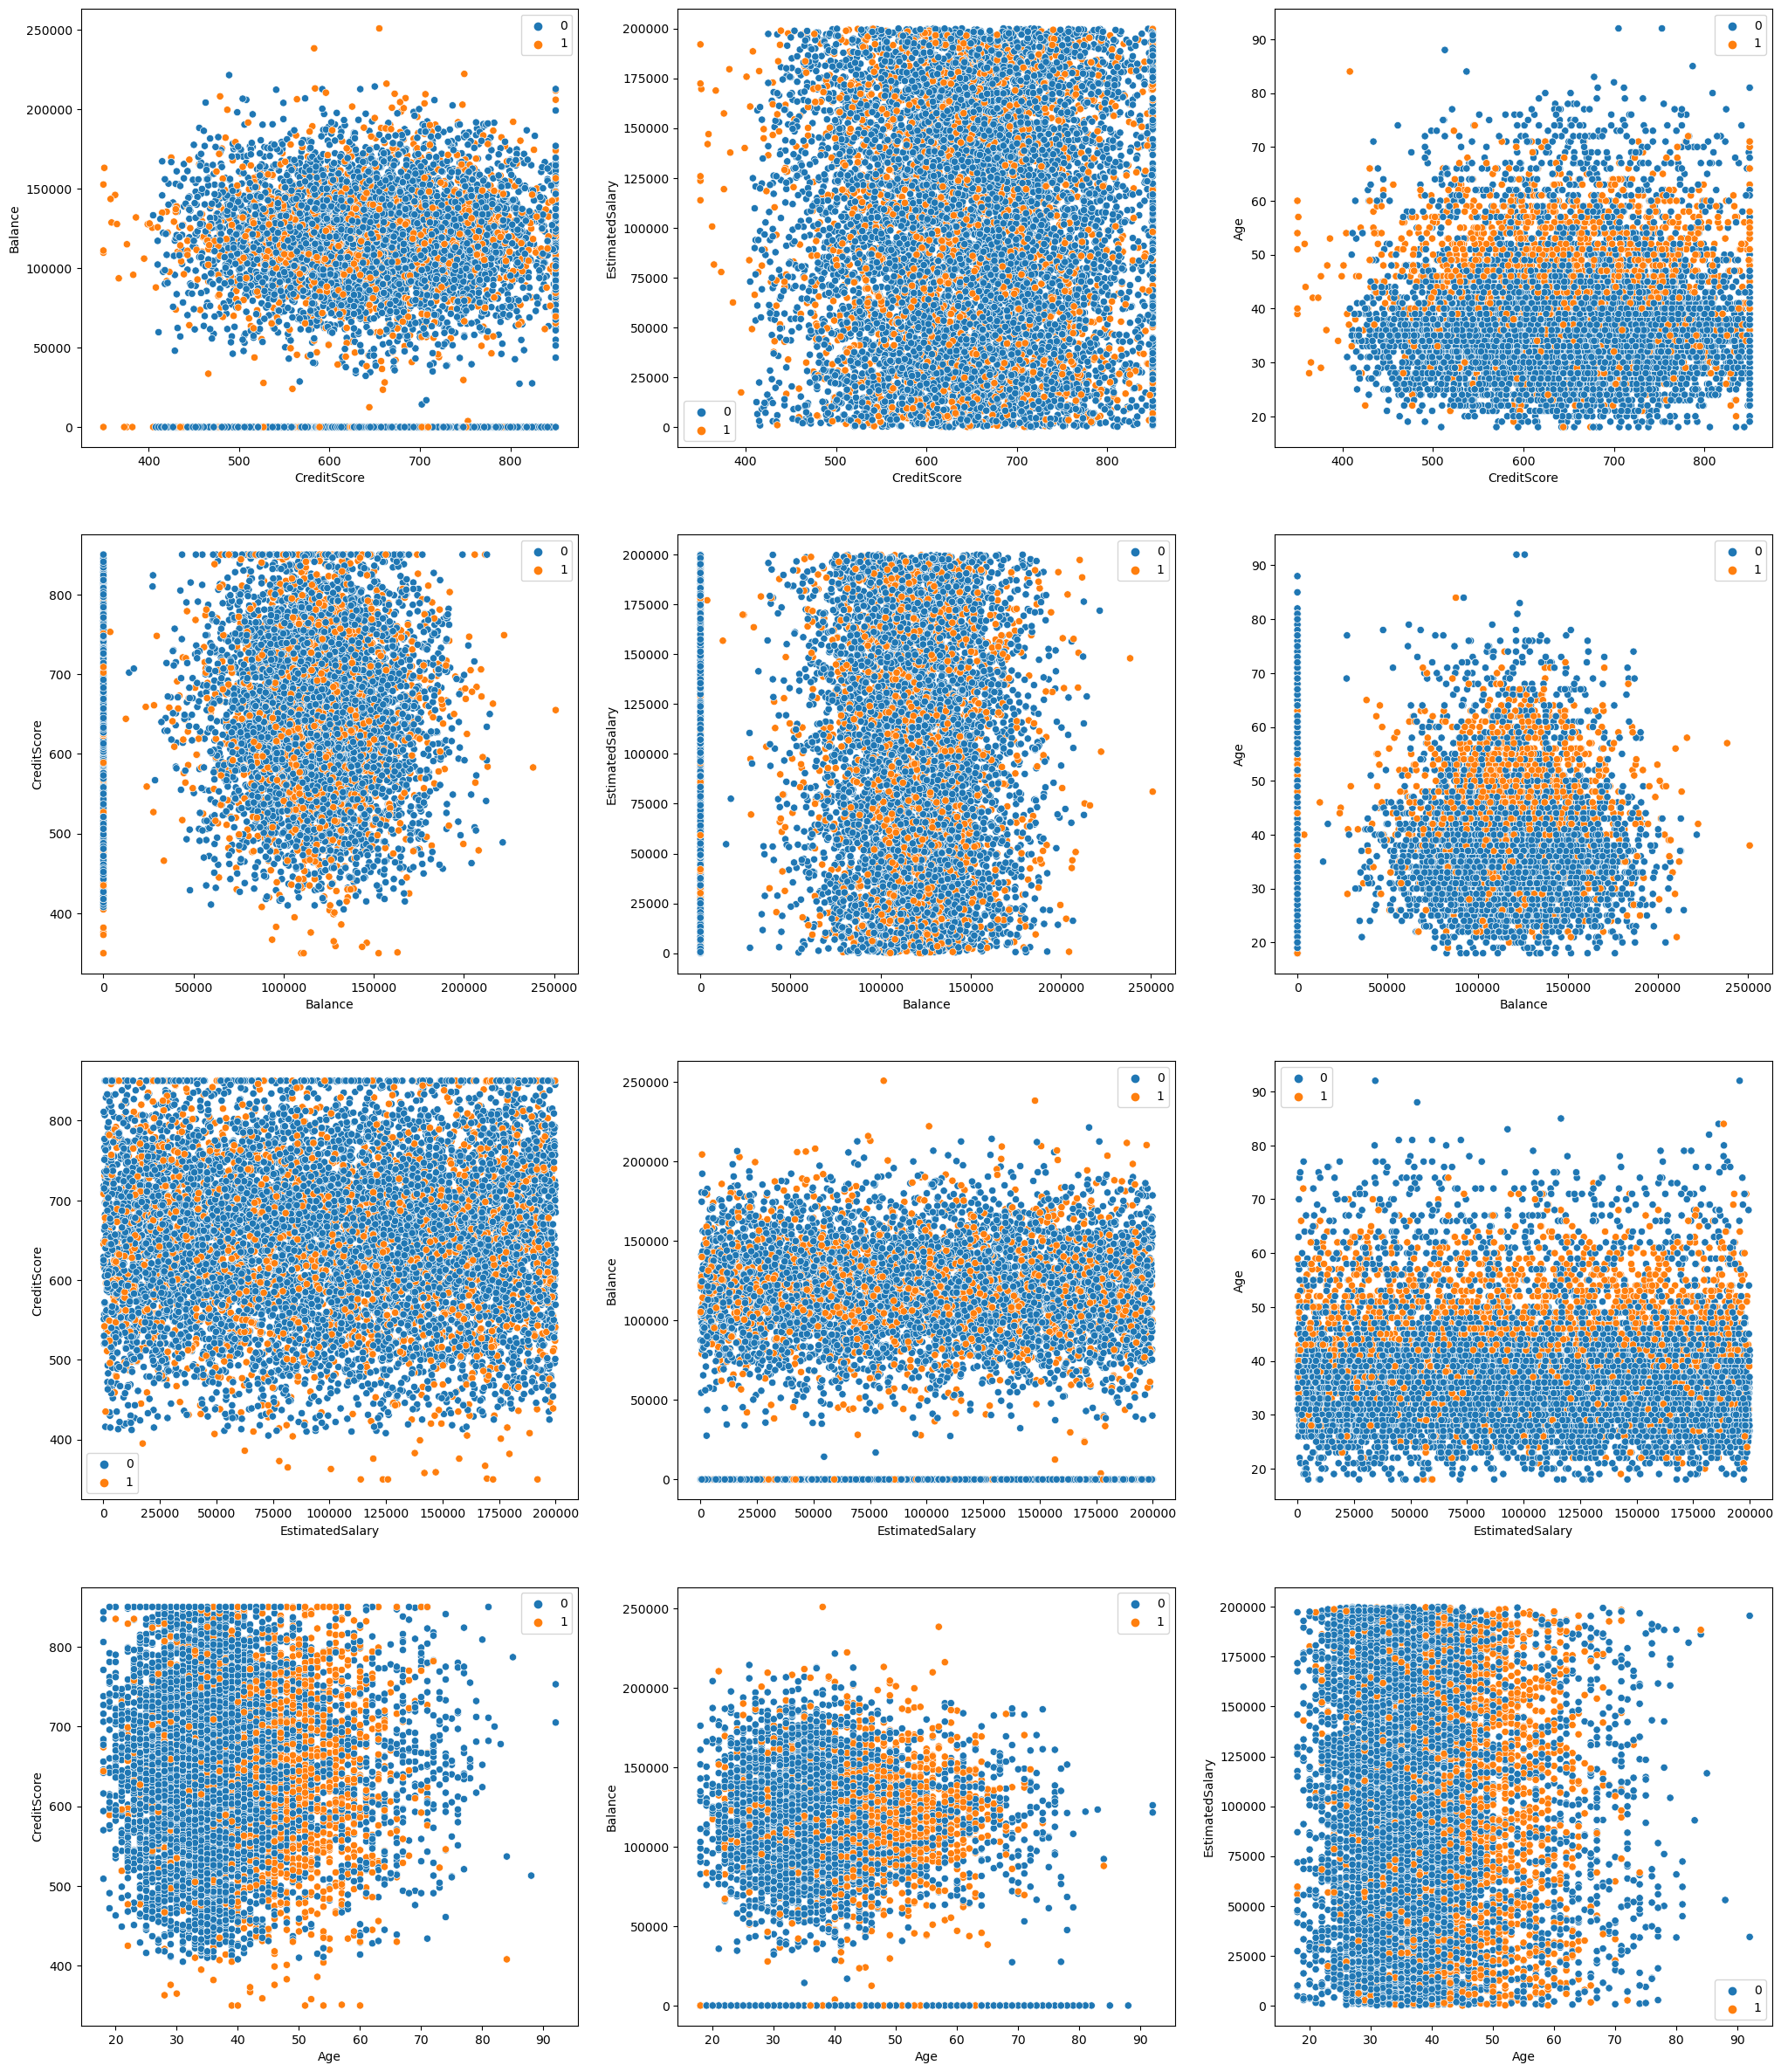

In [1207]:
cols2 = ["CreditScore","Balance","EstimatedSalary","Age"]
scatter_plot(data,*cols2)

1) Balans sətrinə görə dağılımlara baxdıqda görmək olur ki, balansı 0 olan müşdərilərin tərk etmə sayı kifayət qədər az görünür.Böyük ehtimalla balansı 0 olan müşdərilər kreditləri olmayan müşdərilərdir və yaxud yeni daxil olan müşdərilrdir.Bu haqqda dəqiq fikir söylemek olmur hətda Null dəyərlərdə belə ola bilər 0 kimi.
2) Həmçinin balansın dağılımı 50 min ilə 200 min araında daha çox dağılır.
3) Age sətrinə görə dağılımlara baxdıqda görmək olur ki 40-la 60 yaş arasındakı intervalda tərk etmə payı daha çoxdur.

Burada bütün continuous dəyişənlərin öz aralarındakı dağılımlara baxdıq da görmək olur ki, Outlier dəyərlər datamızda kifayət qədər çoxdur.Buda model öyrnəməsində problemlər yarada biləcəyindən bu Outlier dəyərlər üzərində analizlər aparmalıyıq.Lakin bu outlier dəyərlər üzərində analizlər aparmazdan əvvəl Category dəyərləri analiz edək.

In [1208]:
def violin_box_plot(columns1,columns2):
    plt.figure(figsize=(35,80))
    i=1
    for col1 in columns1:
        for col2 in columns2:
            plt.subplot(20,2,i)
            sns.violinplot(data,x = col1,y = col2,hue = "Exited")
            plt.legend(loc = "best")
            i=i+1
            plt.subplot(20,2,i)
            sns.boxplot(data,x = col1,y = col2,hue = "Exited")
            plt.legend(loc = "best")
            i=i+1

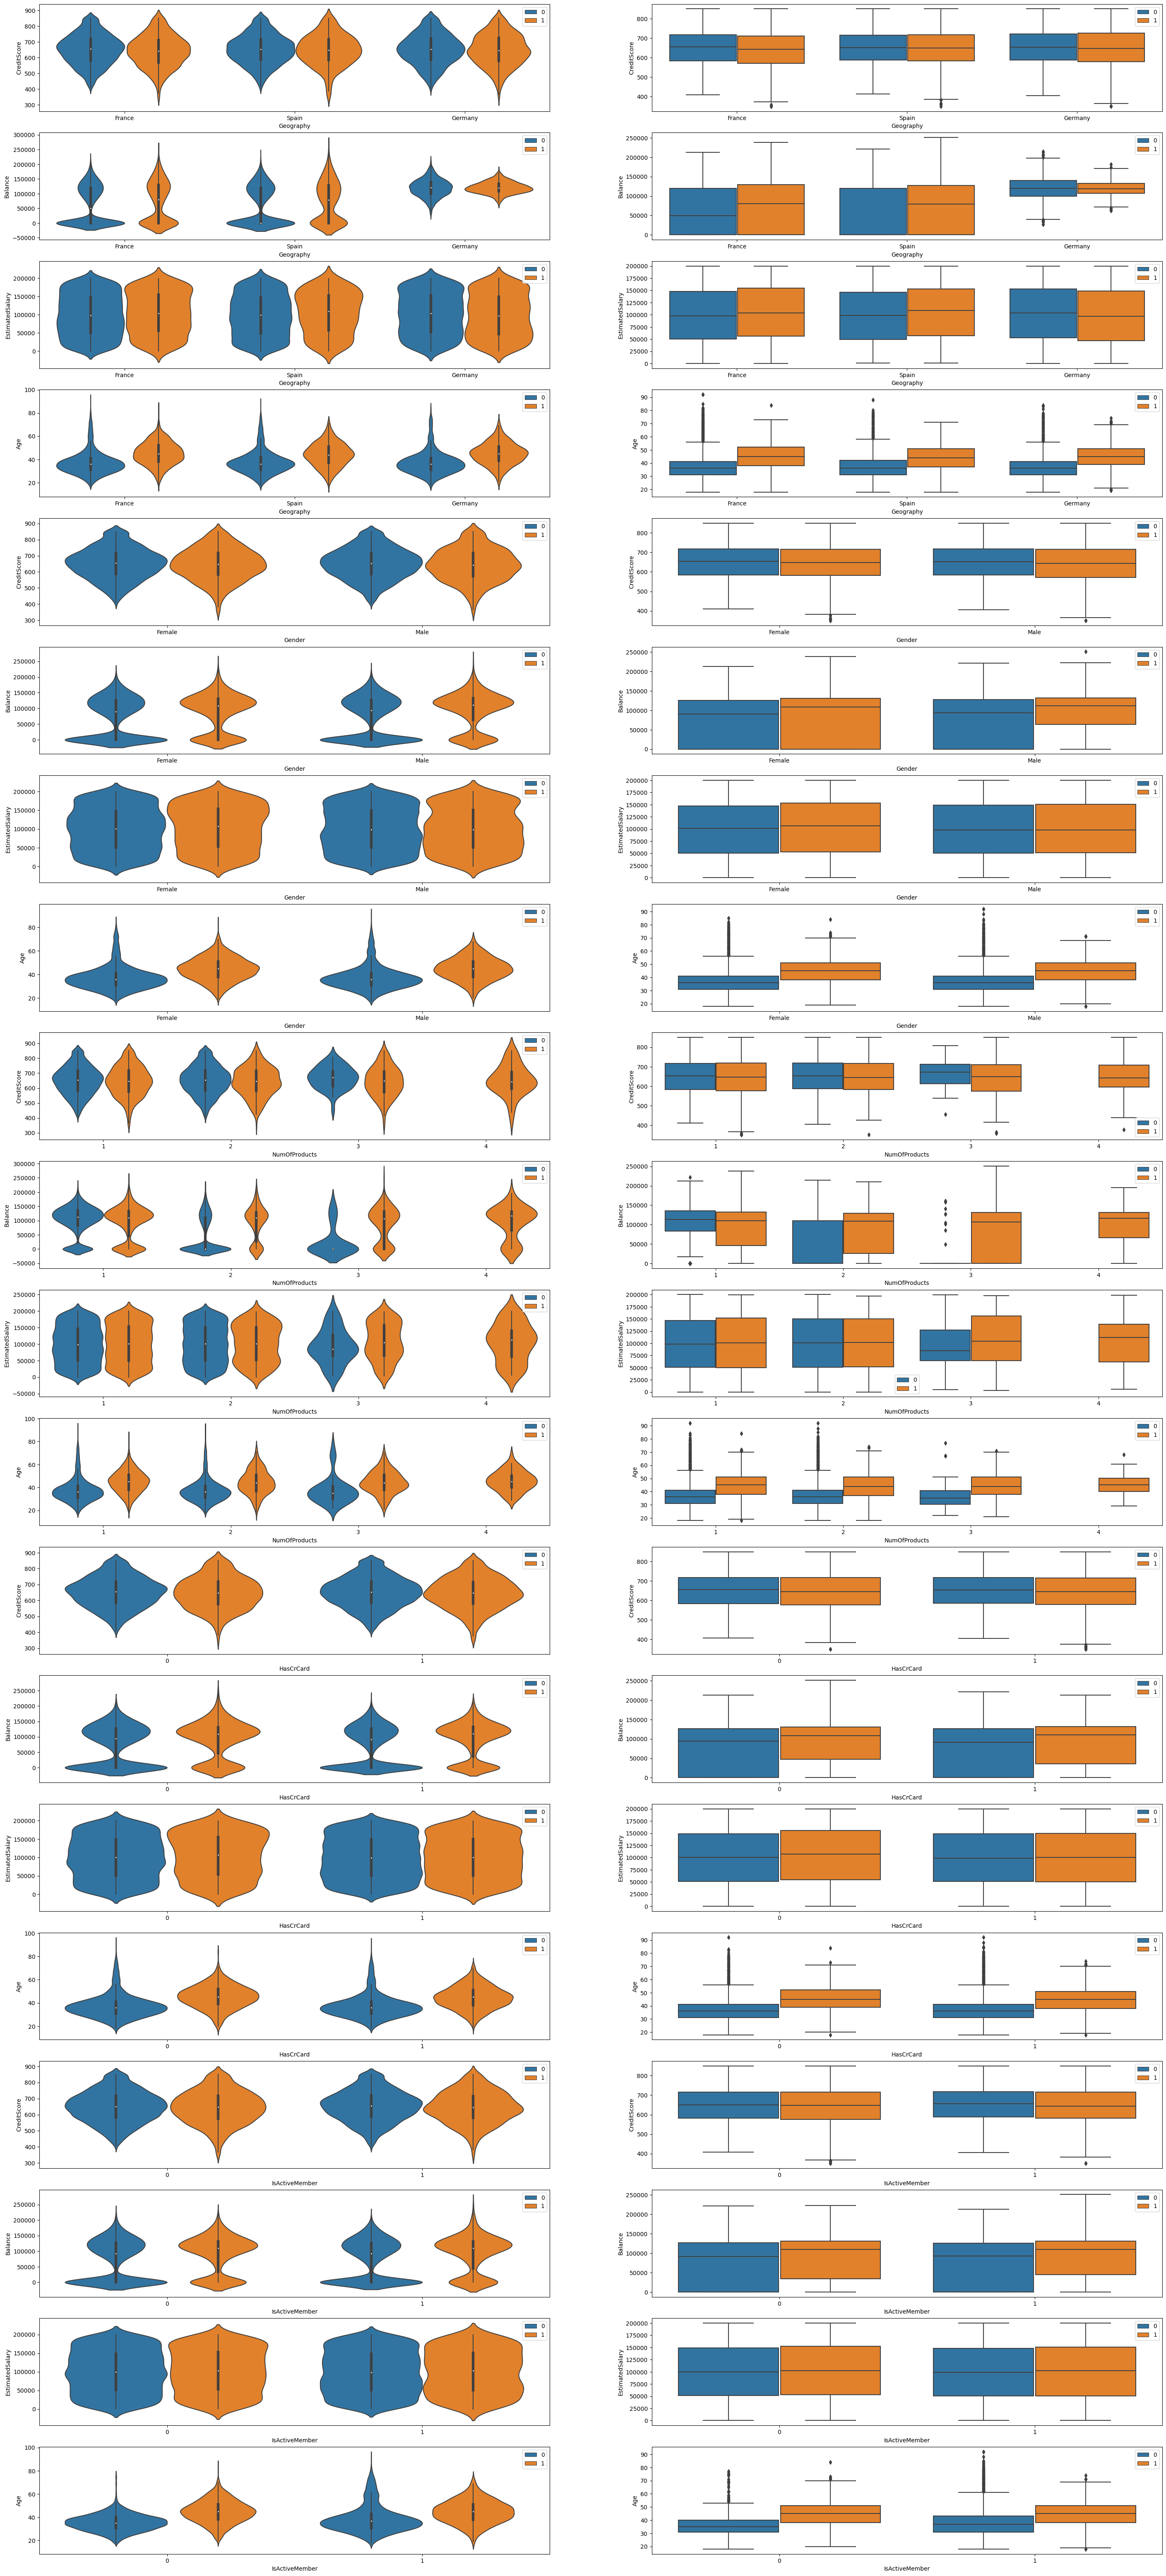

In [1209]:
cols1 = ["Geography","Gender","NumOfProducts","HasCrCard","IsActiveMember"]
cols2 = ["CreditScore","Balance","EstimatedSalary","Age"]
violin_box_plot(cols1,cols2)

1) Qrafiklərdən görünür ki, Məhsul sayı 4 olan bütün müşdərilər bizi tərk edənlər qrupuna aitdir.
2) Dataların öz qrupları arasında Outlierlik və ya dağılımlarında yüksək variance görünmür.

### Corelation heatmap

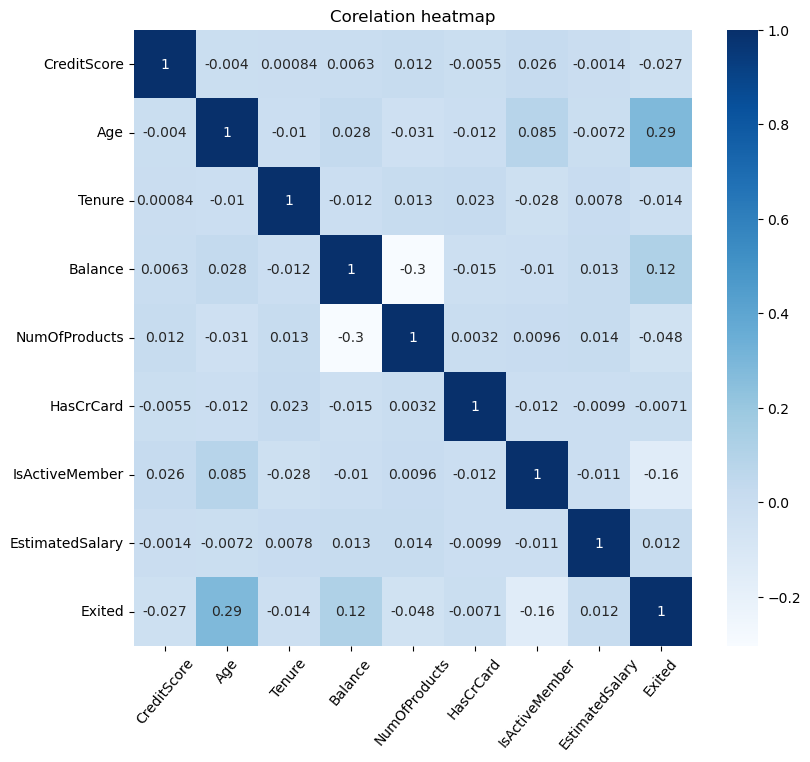

In [1210]:
plt.figure(figsize=(9,8))
sns.heatmap(data.corr(),annot=True,cmap="Blues")
plt.xticks(rotation = 50)
plt.title("Corelation heatmap");

In [1211]:
data.corr()[["Exited"]]

Exited
CreditScore     -0.027094
Age              0.285323
Tenure          -0.014001
Balance          0.118533
NumOfProducts   -0.047820
HasCrCard       -0.007138
IsActiveMember  -0.156128
EstimatedSalary  0.012097
Exited           1.000000

In [1212]:
data.head()

CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42       2       0.00              1   
1          608     Spain  Female   41       1   83807.86              1   
2          502    France  Female   42       8  159660.80              3   
3          699    France  Female   39       1       0.00              2   
4          850     Spain  Female   43       2  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0          1               1        101348.88       1  
1          0               1        112542.58       0  
2          1               0        113931.57       1  
3          0               0         93826.63       0  
4          1               1         79084.10       0

Qrafikdən və DataFarme-dən görünür ki,target sütunu ilə və ya digər sütunlar arasında ciddi şəkildə yüksək corelation yoxdur.

### Age sütunu

Yaş sütunu kateqoriyalara ayıraraq modelə əlavə edək və o şəkildə analizə dəvam edək.

In [1213]:
data["Age"] = data["Age"].apply(lambda x :"Cavan" if (x>=18) and (x<=30) 
                  else "Orta yaş" if (x>=31) and (x<=45)
                  else "Yaşlı" if (x>=46) and (x<=60)
                  else "Qoca")

In [1214]:
data.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Text(0.5, 1.0, 'Exited mean and Age')

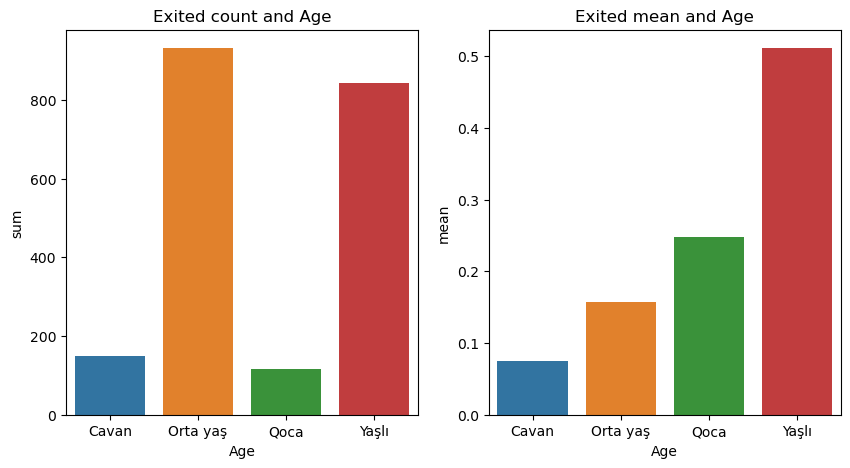

In [1215]:
dage = data.groupby("Age")["Exited"].agg(["mean","sum"]).reset_index()
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.barplot(data = dage,x = "Age", y = "sum")
plt.title("Exited count and Age")
plt.subplot(1,2,2)
sns.barplot(data = dage,x = "Age", y = "mean")
plt.title("Exited mean and Age")

Bu yaş sütununa baxdıqda görmək olur ki, Orta yaş və Yaşlı kateqoriyası daha çox tərk etməyə meyil göstərirlər.Lakin faiz olaraq yaşlı və qoca kateqoriyasına mənsub çəxslər daha çox tərk etməyə meyil göstərirlər.Bu sütunları Ordinal Encoding edərək modelə əlavə edə bilərik.

In [1216]:
data["Age"] = data["Age"].map({"Cavan":1,"Orta yaş":2,"Qoca":3,"Yaşlı":4})

In [1217]:
data.head()

CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female    2       2       0.00              1   
1          608     Spain  Female    2       1   83807.86              1   
2          502    France  Female    2       8  159660.80              3   
3          699    France  Female    2       1       0.00              2   
4          850     Spain  Female    2       2  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0          1               1        101348.88       1  
1          0               1        112542.58       0  
2          1               0        113931.57       1  
3          0               0         93826.63       0  
4          1               1         79084.10       0

### Geography sütunu

In [1218]:
dgeo = data.groupby("Geography")["Exited"].agg(["sum","count"]).reset_index()
dgeo["group_mean"] = dgeo["sum"]/dgeo["count"]
dgeo

Geography  sum  count  group_mean
0    France  810   5014    0.161548
1   Germany  814   2509    0.324432
2     Spain  413   2477    0.166734

#### Pearson's chi-squared

Buradan görünür ki alman əsilli müşddərilər 32.2 faizi,Fransızlar 16.1 faizi İspanların isə ispanlar isə 16.6 faizi tərk etməyə meyillidir. Bəs bu sütunun statistikal olaraq target sütunu ilə müəyyən bağlılığı olub-olamdığını test etmək lazımdır.İki kateqorik sütunun statistikal olaraq  bağımsız olub olmadığını ölçmək üçün Non-parametric test olan "Pearson's chi-squared" testindən istifadə edəcik.5-dən balaca frekanslar toplam frekansın 20 faizindən balaca olduğunu dəqiqiləşdirdikdən sonra "Pearson's chi-squared" testini quraq.

In [1219]:
#frekans dəyərləinə baxaq.
table = pd.crosstab(index = data["Geography"],columns=data["Exited"])
table

Exited        0    1
Geography           
France     4204  810
Germany    1695  814
Spain      2064  413

In [1220]:
#testi quraq
test,p_value,sd,expect_value = stats.chi2_contingency(table,correction=False)

In [1221]:
if p_value<0.05:
    print("İki sütun arasında bir bağlılıq vardır.")
else:
    print("İki sütun arasında bir bağlılıq yoxdur.")

İki sütun arasında bir bağlılıq vardır.


İki sütun arasında 95 faiz ehtimalla bağlılıq olduğu üçün biz Geography sütununu modelə əlavə edəcik.Tərk etmə faizi ən çox Alman müşdərilərdə görüldüyü üçün və Fransız və İspan müşdərilər arasında isə faiz olaraq ciddi fərq olmadığı üçün biz alman müşdəriləri 1 lə Fransız və ispan müşdəriləri isə 0 la kodlayaraq modelə əlavə edəcik.

In [1222]:
data["Geography"] = np.where(data["Geography"]=="Germany",1,0)

### Gender sütunu

Gender sütununu One Hot encoding edərək modelə əlavə edə bilərik.

In [1223]:
data = pd.get_dummies(data=data,columns=["Gender"],drop_first=True)

In [1224]:
data.head()

CreditScore  Geography  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0          619          0    2       2       0.00              1          1   
1          608          0    2       1   83807.86              1          0   
2          502          0    2       8  159660.80              3          1   
3          699          0    2       1       0.00              2          0   
4          850          0    2       2  125510.82              1          1   

   IsActiveMember  EstimatedSalary  Exited  Gender_Male  
0               1        101348.88       1            0  
1               1        112542.58       0            0  
2               0        113931.57       1            0  
3               0         93826.63       0            0  
4               1         79084.10       0            0

### Outlier təmizlənməsi 

Outlierlərin analiz etmək üçün ilk öncə çoxlu dəyişənlərin birlikdə yaratdığı Outlier dəyərlərə baxaq və onları model üzrə analiz edək.Bunun üçün LocalOutlierFactor-dan istifadə edəcik.

In [1225]:
lof = LocalOutlierFactor(n_neighbors=20,contamination=0.1)
#datada olan 10 faizlik outlier dəyərlər.
predict = lof.fit_predict(data)

In [1226]:
#outlier skorlar
predict_score = lof.negative_outlier_factor_

In [1227]:
sorted(predict_score)[:20]

[-31.509831393308787,
 -27.45902712234865,
 -26.16016713067059,
 -19.316188139131864,
 -18.14010775167431,
 -17.8456565948766,
 -7.518223366968927,
 -2.576728565740271,
 -1.9437556890558632,
 -1.8760655987451589,
 -1.8695208887697645,
 -1.8484697444964042,
 -1.7831825255137126,
 -1.7342412260374451,
 -1.6544472443724718,
 -1.6293598894695251,
 -1.6104223727870344,
 -1.5697075258275177,
 -1.5619058231148846,
 -1.5533633193372265]

Burada hər bir sətir üçün Outlier skorları alırıq.Və -1.94 dən sonra bütün skorların bir birlərinə yaxınlıq göstərdiyini, -1.94 dəyərindən böyük dəyərlərin dağılımları fərqlilik göstərdiyi və Outlier dəyərlər ola biləcəyini analiz edirik.-1.94 dəyərini özümüzə treshold götürək və bu dəyərdən kiçik dəyərləri modelimizdən kənarlaşdıraq.

In [1228]:
tresh_old = sorted(predict_score)[:20][8]
#tresholdan kiçik dəyərləri kənarlaşdırırıq
outlier_tf = predict_score>tresh_old
data = data[outlier_tf]

In [1229]:
data

CreditScore  Geography  Age  Tenure    Balance  NumOfProducts  \
0             619          0    2       2       0.00              1   
1             608          0    2       1   83807.86              1   
2             502          0    2       8  159660.80              3   
3             699          0    2       1       0.00              2   
4             850          0    2       2  125510.82              1   
...           ...        ...  ...     ...        ...            ...   
9995          771          0    2       5       0.00              2   
9996          516          0    2      10   57369.61              1   
9997          709          0    2       7       0.00              1   
9998          772          1    2       3   75075.31              2   
9999          792          0    1       4  130142.79              1   

      HasCrCard  IsActiveMember  EstimatedSalary  Exited  Gender_Male  
0             1               1        101348.88       1            0  
1             0               1        112542.58       0            0  
2             1               0        113931.57       1            0  
3             0               0         93826.63       0            0  
4             1               1         79084.10       0            0  
...         ...             ...              ...     ...          ...  
9995          1               0         96270.64       0            1  
9996          1               1        101699.77       0            1  
9997          0               1         42085.58       1            0  
9998          1               0         92888.52       1            1  
9999          1               0         38190.78       0            0  

[9991 rows x 11 columns]

İndi isə hər bir sütun üçün Outlier dəyərlərə baxaq və Onları necə analiz edə bilərik dəqiqləşdirək.Bunun üçün Box plotdan istifadə edərək bir funksiya yazaq.

In [1230]:
def boxplot(data,columns):
    plt.figure(figsize=(25,30))
    i=1
    for col1 in columns:
            plt.subplot(4,3,i)
            sns.boxplot(data,y = col1)
            i=i+1

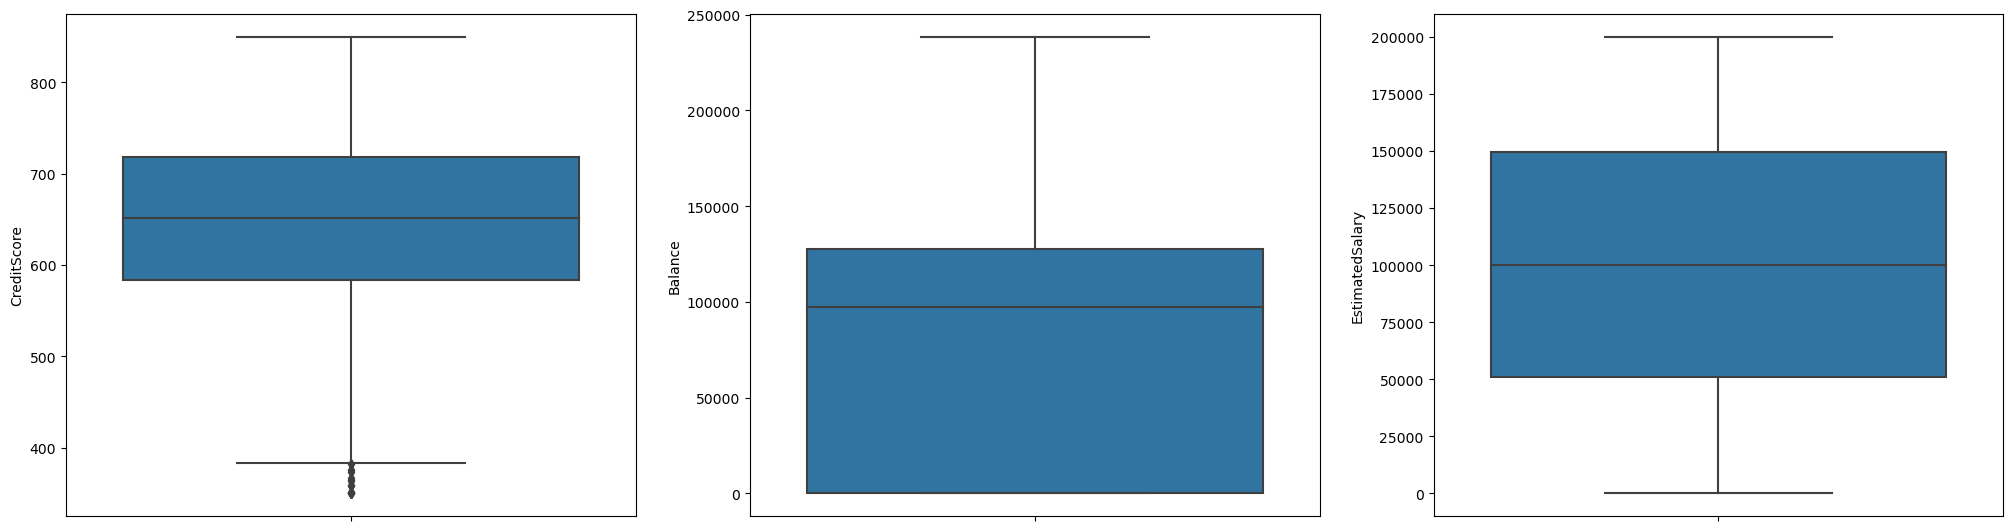

In [1231]:
cols3 = ["CreditScore","Balance","EstimatedSalary"]
boxplot(data=data,columns=cols3)
#Yalnız credit skorlarında Outier dəyərlər olduğunu analiz edirik.
#Bu dəyərlərin sayına baxaq əgər azlıq etsə həmin dəyərləri modeldən kənarlaşdırarıq

In [1232]:
Q1 = data["CreditScore"].quantile(0.25)
Q3 = data["CreditScore"].quantile(0.75)
lower = Q1-(Q3-Q1)*1.5

In [1233]:
#outlier dəyərləri kənarlaşdıraq.
data = data[data["CreditScore"]>=lower]

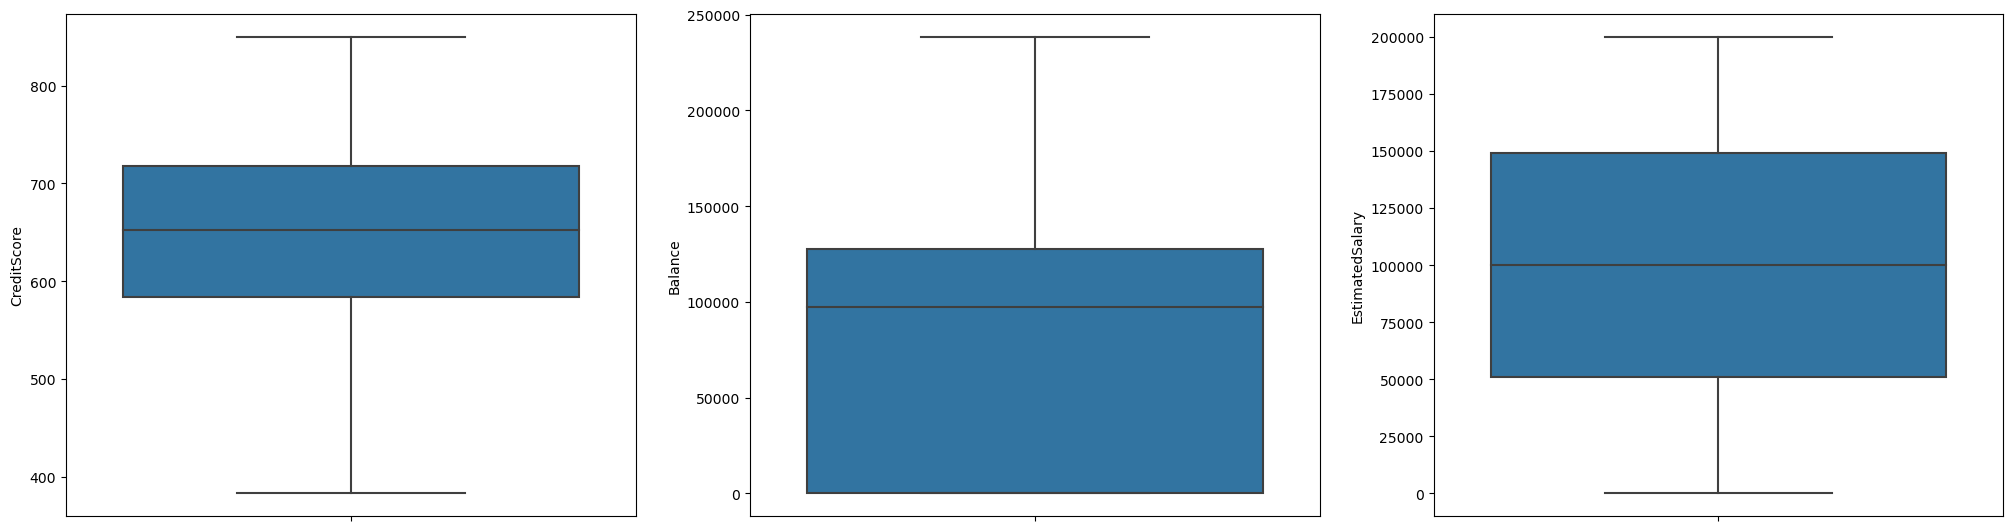

In [1234]:
#outlier dəyərlərin kənarlaşmış halı
boxplot(data=data,columns=cols3)

### CreditScore sütunu

In [1235]:
data.head()

CreditScore  Geography  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0          619          0    2       2       0.00              1          1   
1          608          0    2       1   83807.86              1          0   
2          502          0    2       8  159660.80              3          1   
3          699          0    2       1       0.00              2          0   
4          850          0    2       2  125510.82              1          1   

   IsActiveMember  EstimatedSalary  Exited  Gender_Male  
0               1        101348.88       1            0  
1               1        112542.58       0            0  
2               0        113931.57       1            0  
3               0         93826.63       0            0  
4               1         79084.10       0            0

Əksər kredit balları 300-850 arasında dəyişir.Bizdəki hesablamda da kredit skorları 300 ilə 850 arasındakı dəyərləndirilir.Biz bu sütunu 100 bölərik və tam hissəsini alaraq modelimizə o şəkildə əlavə edə bilərik.

In [1236]:
data["CreditScore"] = data["CreditScore"]//100

In [1237]:
data.head()

CreditScore  Geography  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0            6          0    2       2       0.00              1          1   
1            6          0    2       1   83807.86              1          0   
2            5          0    2       8  159660.80              3          1   
3            6          0    2       1       0.00              2          0   
4            8          0    2       2  125510.82              1          1   

   IsActiveMember  EstimatedSalary  Exited  Gender_Male  
0               1        101348.88       1            0  
1               1        112542.58       0            0  
2               0        113931.57       1            0  
3               0         93826.63       0            0  
4               1         79084.10       0            0

### Tenure sütunu

Text(0.5, 1.0, 'Exited mean and Tenure')

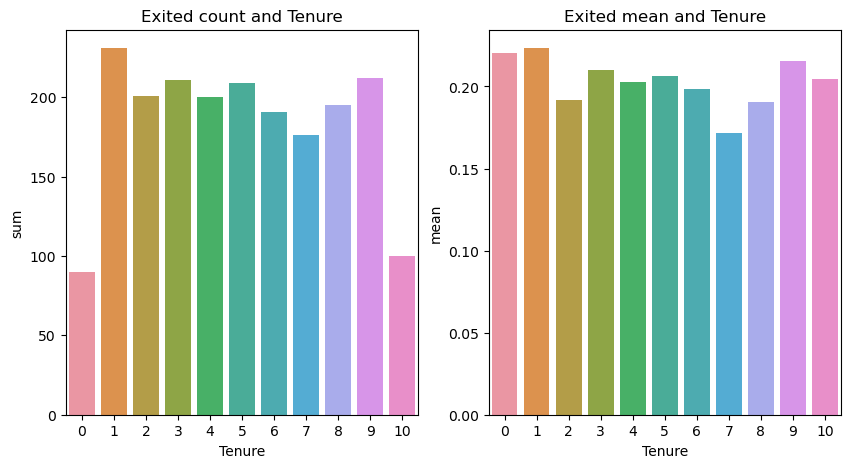

In [1238]:
dage = data.groupby("Tenure")["Exited"].agg(["mean","sum"]).reset_index()
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.barplot(data = dage,x = "Tenure", y = "sum")
plt.title("Exited count and Tenure")
plt.subplot(1,2,2)
sns.barplot(data = dage,x = "Tenure", y = "mean")
plt.title("Exited mean and Tenure")

Göründüyü kimi bu sütunu frekans dəyərlərinə görə analiz etmək çətin olur.Qrafikdən mənalı nəsə çıxarmaq mümkün olmur.Gəlin bu sütunu target sütunu ilə bağlılığını test edək, Əgər müəyyən bağlılığı olmasa Tenure sütununu modeldən kənarlaşdırarıq, Əgər bağlılığ olsa isə One hot encoding edərək modelə əlavə edərik.

In [1239]:
#frekans dəyərləinə baxaq.
table = pd.crosstab(index = data["Tenure"],columns=data["Exited"])
table

Exited    0    1
Tenure          
0       318   90
1       803  231
2       846  201
3       795  211
4       786  200
5       803  209
6       771  191
7       851  176
8       827  195
9       771  212
10      389  100

In [1240]:
#testi quraq
test,p_value,sd,expect_value = stats.chi2_contingency(table,correction=False)

In [1241]:
if p_value<0.05:
    print("İki sütun arasında bir bağlılıq vardır.")
else:
    print("İki sütun arasında bir bağlılıq yoxdur.")

İki sütun arasında bir bağlılıq yoxdur.


İki sütun arasında 95 faiz ehtimalla bağlılıq olduğu üçün biz Tenure sütununu modelə əlavə edəcik.One Hot Encoding edərək bu sütunu modelə əlavə edək.

In [1242]:
data = pd.get_dummies(data=data,columns=["Tenure"],drop_first=True)

In [1243]:
data.head()

CreditScore  Geography  Age    Balance  NumOfProducts  HasCrCard  \
0            6          0    2       0.00              1          1   
1            6          0    2   83807.86              1          0   
2            5          0    2  159660.80              3          1   
3            6          0    2       0.00              2          0   
4            8          0    2  125510.82              1          1   

   IsActiveMember  EstimatedSalary  Exited  Gender_Male  Tenure_1  Tenure_2  \
0               1        101348.88       1            0         0         1   
1               1        112542.58       0            0         1         0   
2               0        113931.57       1            0         0         0   
3               0         93826.63       0            0         1         0   
4               1         79084.10       0            0         0         1   

   Tenure_3  Tenure_4  Tenure_5  Tenure_6  Tenure_7  Tenure_8  Tenure_9  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         0         0   
2         0         0         0         0         0         1         0   
3         0         0         0         0         0         0         0   
4         0         0         0         0         0         0         0   

   Tenure_10  
0          0  
1          0  
2          0  
3          0  
4          0

### NumOfProducts sütunu

Text(0.5, 1.0, 'Exited mean and NumOfProducts')

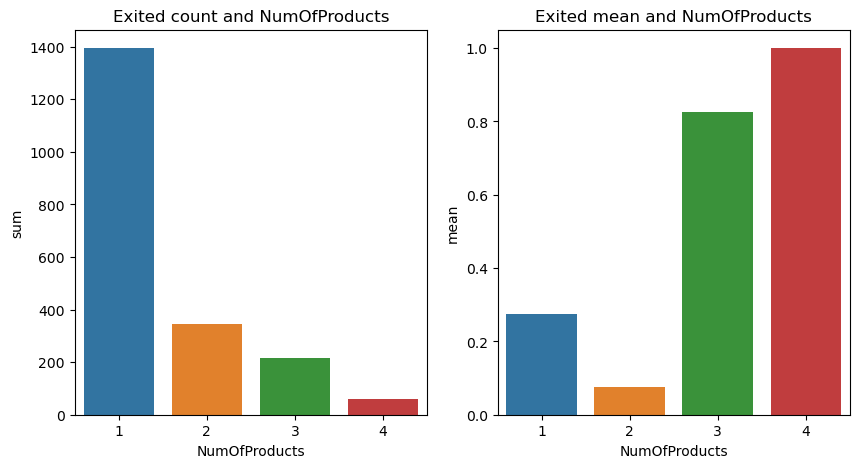

In [1244]:
dage = data.groupby("NumOfProducts")["Exited"].agg(["mean","sum"]).reset_index()
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.barplot(data = dage,x = "NumOfProducts", y = "sum")
plt.title("Exited count and NumOfProducts")
plt.subplot(1,2,2)
sns.barplot(data = dage,x = "NumOfProducts", y = "mean")
plt.title("Exited mean and NumOfProducts")

In [1245]:
table = pd.crosstab(index = data["NumOfProducts"],columns=data["Exited"])

Bu sütunuda test edək və target sütunu ilə bağlılığı olsa modelə əlavə edərik, əks halda modeldən kənarlaşdırarıq.

In [1246]:
#testi quraq
test,p_value,sd,expect_value = stats.chi2_contingency(table,correction=False)

In [1247]:
if p_value<0.05:
    print("İki sütun arasında bir bağlılıq vardır.")
else:
    print("İki sütun arasında bir bağlılıq yoxdur.")

İki sütun arasında bir bağlılıq vardır.


İki sütun arasında 95 faiz ehtimalla bağlılıq olduğu üçün biz NumOfProducts sütununu modelə əlavə edəcik.

In [1248]:
data = pd.get_dummies(data=data,columns=["NumOfProducts"],drop_first=True)

In [1249]:
data.head()

CreditScore  Geography  Age    Balance  HasCrCard  IsActiveMember  \
0            6          0    2       0.00          1               1   
1            6          0    2   83807.86          0               1   
2            5          0    2  159660.80          1               0   
3            6          0    2       0.00          0               0   
4            8          0    2  125510.82          1               1   

   EstimatedSalary  Exited  Gender_Male  Tenure_1  ...  Tenure_4  Tenure_5  \
0        101348.88       1            0         0  ...         0         0   
1        112542.58       0            0         1  ...         0         0   
2        113931.57       1            0         0  ...         0         0   
3         93826.63       0            0         1  ...         0         0   
4         79084.10       0            0         0  ...         0         0   

   Tenure_6  Tenure_7  Tenure_8  Tenure_9  Tenure_10  NumOfProducts_2  \
0         0         0         0         0          0                0   
1         0         0         0         0          0                0   
2         0         0         1         0          0                0   
3         0         0         0         0          0                1   
4         0         0         0         0          0                0   

   NumOfProducts_3  NumOfProducts_4  
0                0                0  
1                0                0  
2                1                0  
3                0                0  
4                0                0  

[5 rows x 22 columns]

### EstimatedSalary sütunu

Bu sütun böyük ehtimalla bir şəxsin illik gəlirinin göstəricisidir.Biz bunu 12 yə bölərək normallaşdırıb şəxsin aylıq gəlirini əldə edərik.Daha sonra 1 lə 10 arasında MiniMAX scaler vasitəsi ilə bu sütunu normallaşdırarıq.

In [1250]:
data["EstimatedSalary"] = data["EstimatedSalary"]/12

In [1251]:
scaler = MinMaxScaler((1,10))
data["EstimatedSalary"] = scaler.fit_transform(data["EstimatedSalary"].values.reshape(-1,1))

### Balance sütunu

Balans sütununuda normallaşdıraraq modelə əlavə edək.

In [1252]:
scaler = MinMaxScaler((1,10))
data["Balance"] = scaler.fit_transform(data["Balance"].values.reshape(-1,1))

In [1253]:
data.head()

CreditScore  Geography  Age   Balance  HasCrCard  IsActiveMember  \
0            6          0    2  1.000000          1               1   
1            6          0    2  4.164052          0               1   
2            5          0    2  7.027778          1               0   
3            6          0    2  1.000000          0               0   
4            8          0    2  5.738491          1               1   

   EstimatedSalary  Exited  Gender_Male  Tenure_1  ...  Tenure_4  Tenure_5  \
0         5.560614       1            0         0  ...         0         0   
1         6.064379       0            0         1  ...         0         0   
2         6.126889       1            0         0  ...         0         0   
3         5.222080       0            0         1  ...         0         0   
4         4.558603       0            0         0  ...         0         0   

   Tenure_6  Tenure_7  Tenure_8  Tenure_9  Tenure_10  NumOfProducts_2  \
0         0         0         0         0          0                0   
1         0         0         0         0          0                0   
2         0         0         1         0          0                0   
3         0         0         0         0          0                1   
4         0         0         0         0          0                0   

   NumOfProducts_3  NumOfProducts_4  
0                0                0  
1                0                0  
2                1                0  
3                0                0  
4                0                0  

[5 rows x 22 columns]

### Train və Test split

In [1254]:
# x və y -datalarımızı ayırarıq.
X = data.drop(columns="Exited",axis = 1).values
y = data["Exited"].values

In [1255]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 42)

### Standartlaşdırma

In [1279]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [1305]:
model = Sequential()
model.add(Dense(units = 100, activation = 'relu'))
model.add(Dense(units = 50, activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [1306]:
model.fit(X_train,y_train,epochs=80, validation_data=(X_test, y_test) )

Epoch 1/80
250/250 [==============================] - 1s 2ms/step - loss: 0.3848 - accuracy: 0.8415 - val_loss: 0.3725 - val_accuracy: 0.8412
Epoch 2/80
250/250 [==============================] - 0s 1ms/step - loss: 0.3583 - accuracy: 0.8520 - val_loss: 0.3723 - val_accuracy: 0.8417
Epoch 3/80
250/250 [==============================] - 0s 1ms/step - loss: 0.3525 - accuracy: 0.8551 - val_loss: 0.3736 - val_accuracy: 0.8427
Epoch 4/80
250/250 [==============================] - 0s 1ms/step - loss: 0.3471 - accuracy: 0.8565 - val_loss: 0.3762 - val_accuracy: 0.8427
Epoch 5/80
250/250 [==============================] - 0s 1ms/step - loss: 0.3442 - accuracy: 0.8563 - val_loss: 0.3662 - val_accuracy: 0.8467
Epoch 6/80
250/250 [==============================] - 0s 1ms/step - loss: 0.3409 - accuracy: 0.8586 - val_loss: 0.3699 - val_accuracy: 0.8447
Epoch 7/80
250/250 [==============================] - 0s 1ms/step - loss: 0.3371 - accuracy: 0.8615 - val_loss: 0.3667 - val_accuracy: 0.8442
Epoch 

250/250 [==============================] - 0s 1ms/step - loss: 0.2259 - accuracy: 0.9091 - val_loss: 0.4718 - val_accuracy: 0.8292
Epoch 59/80
250/250 [==============================] - 0s 959us/step - loss: 0.2240 - accuracy: 0.9049 - val_loss: 0.4957 - val_accuracy: 0.8262
Epoch 60/80
250/250 [==============================] - 0s 965us/step - loss: 0.2225 - accuracy: 0.9078 - val_loss: 0.4869 - val_accuracy: 0.8357
Epoch 61/80
250/250 [==============================] - 0s 997us/step - loss: 0.2199 - accuracy: 0.9084 - val_loss: 0.4828 - val_accuracy: 0.8302
Epoch 62/80
250/250 [==============================] - 0s 1ms/step - loss: 0.2198 - accuracy: 0.9080 - val_loss: 0.5073 - val_accuracy: 0.8262
Epoch 63/80
250/250 [==============================] - 0s 1ms/step - loss: 0.2156 - accuracy: 0.9113 - val_loss: 0.5031 - val_accuracy: 0.8297
Epoch 64/80
250/250 [==============================] - 0s 1ms/step - loss: 0.2146 - accuracy: 0.9118 - val_loss: 0.4954 - val_accuracy: 0.8332
Epoch

In [1307]:
training_score = model.evaluate(X_train,y_train,verbose=0)
test_score = model.evaluate(X_test,y_test,verbose=0)

In [1308]:
# Train və testin skorları
print("Train Score: {0:.4f}".format(training_score[0]))
print("Test Score: {0:.4f}".format(test_score[0]))

Train Score: 0.1681
Test Score: 0.5427


In [1309]:
# testin probability dəyərləri
test_predictions_prob = model.predict(X_test)

63/63 [==============================] - 0s 664us/step


In [1310]:
# test predict dəyərləri
threshold = 0.5
test_predictions = (test_predictions_prob > threshold).astype("int32")
test_predictions

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [1311]:
# test dəyərlərimiz ilə predict dəyərlərdən ibarət dataframe
pred_df = pd.DataFrame(y_test,columns=['Test Y'])
test_predictions = pd.Series(test_predictions.reshape(1996,))
pred_df = pd.concat([pred_df,test_predictions],axis=1)
pred_df.columns = ['Test Y','Model Predictions']

In [1312]:
pred_df

Test Y  Model Predictions
0          0                  0
1          0                  0
2          1                  0
3          0                  0
4          1                  0
...      ...                ...
1991       0                  0
1992       0                  0
1993       0                  0
1994       0                  0
1995       1                  0

[1996 rows x 2 columns]

In [1313]:
#dataframe ön baxış
pred_df.head(30)

Test Y  Model Predictions
0        0                  0
1        0                  0
2        1                  0
3        0                  0
4        1                  0
5        0                  0
6        0                  0
7        0                  0
8        0                  0
9        0                  0
10       0                  0
11       0                  0
12       0                  0
13       0                  0
14       0                  1
15       0                  0
16       0                  0
17       0                  0
18       0                  0
19       1                  0
20       0                  0
21       0                  0
22       0                  0
23       0                  0
24       1                  1
25       1                  0
26       0                  0
27       0                  0
28       0                  0
29       0                  0

### Confusion Matrix

Text(50.722222222222214, 0.5, 'Values')

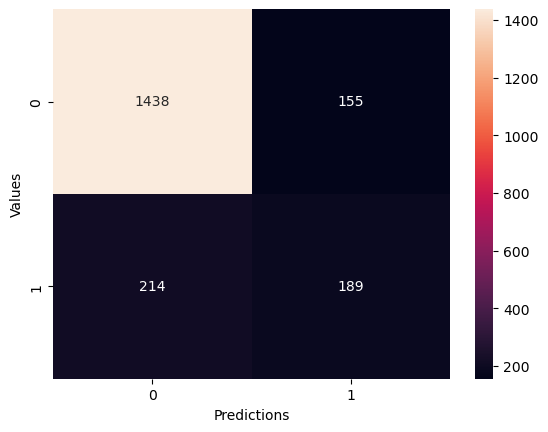

In [1314]:
sns.heatmap(confusion_matrix(pred_df['Test Y'],pred_df['Model Predictions']),annot=True,fmt="0.0f")
plt.xlabel("Predictions")
plt.ylabel("Values")

### Roc Curve

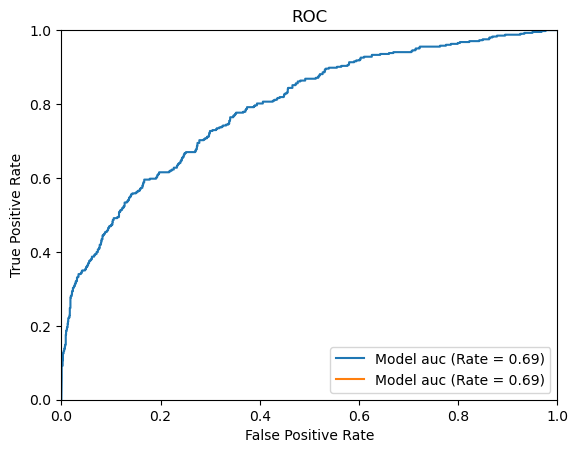

In [1315]:
tpr,fpr,treshold = roc_curve(pred_df['Test Y'],test_predictions_prob)
auc = roc_auc_score(pred_df['Test Y'],pred_df['Model Predictions'])
plt.plot(tpr,fpr,treshold,label = "Model auc (Rate = %.2f)"%auc)
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC")
plt.legend(loc = "lower right")